# Angelene Arito DSC540-910 Final Project

Import packages

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time
import sys
import csv
from operator import itemgetter
import time

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

Import data from 20M set

In [3]:
g_scores = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/genome_scores.csv")
g_tags = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/genome_tags.csv")
link = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/link.csv")
movie = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/movie.csv")
rating = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/rating.csv")
tag = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/tag.csv")

Look at first few rows of each set

In [4]:
g_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [5]:
g_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [6]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movie['year'] = movie['title'].str[-6:]
movie['year'] = movie['year'].replace(regex=['\('], value='')
movie['year'] = movie['year'].replace(regex=['\)'], value='')
movie['title'] = movie['title'].str[:-7]
movie.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [9]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [10]:
tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


Check for missing data

In [11]:
link[(link.tmdbId.isnull())]

,movieId,imdbId,tmdbId
140,142,94878,NaN
598,604,115978,NaN
708,720,118114,NaN
709,721,114103,NaN
718,730,125877,NaN
727,739,116559,NaN
756,769,116992,NaN
757,770,38426,NaN
778,791,113610,NaN
806,821,112746,NaN


In [12]:
link.dropna(inplace=True)

In [13]:
tag[tag.tag.isnull()]

,userId,movieId,tag,timestamp
373276,116460,123,NaN,2008-01-04 12:47:47
373277,116460,346,NaN,2008-01-04 13:05:46
373281,116460,1184,NaN,2008-01-04 13:11:01
373288,116460,1785,NaN,2008-01-04 13:06:46
373289,116460,2194,NaN,2008-01-04 12:44:37
373291,116460,2691,NaN,2008-01-04 12:50:02
373299,116460,4103,NaN,2008-01-04 13:05:20
373301,116460,4473,NaN,2008-01-04 12:50:40
373303,116460,4616,NaN,2008-01-04 13:14:01
373319,116460,7624,NaN,2008-01-04 13:11:06


In [14]:
tag.dropna(inplace=True)

Data sizes

In [15]:
print(" g_scores: ", g_scores.shape, "\n", "g_tags: ", g_tags.shape, "\n", "link: ", link.shape, "\n",
      "movie: ", movie.shape, "\n", "rating: ", rating.shape,"\n", "tag: ", tag.shape)

 g_scores:  (11709768, 3) 
 g_tags:  (1128, 2) 
 link:  (27026, 3) 
 movie:  (27278, 4) 
 rating:  (20000263, 4) 
 tag:  (465548, 4)


Merge data on common fields to reduce dataset number

In [16]:
movies = pd.merge(movie, g_scores, on="movieId")

In [17]:
movies = pd.merge(movies, g_tags, on="tagId")

In [18]:
movies = pd.merge(movies, link, on="movieId")

In [19]:
movies.head()

,movieId,title,genres,year,tagId,relevance,tag,imdbId,tmdbId
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,0.02500,007,114709,862.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,2,0.02500,007 (series),114709,862.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,3,0.05775,18th century,114709,862.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,4,0.09675,1920s,114709,862.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5,0.14675,1930s,114709,862.0


Rearrange columns

In [20]:
cols = movies.columns.tolist()
cols

['movieId',
 'title',
 'genres',
 'year',
 'tagId',
 'relevance',
 'tag',
 'imdbId',
 'tmdbId']

In [21]:
cols = ['movieId','imdbId', 'tmdbId', 'title', 'genres', 'tagId', 'tag', 'relevance']
movies = movies[cols]

In [22]:
movies.head()

,movieId,imdbId,tmdbId,title,genres,tagId,tag,relevance
0,1,114709,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,007,0.02500
1,1,114709,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2,007 (series),0.02500
2,1,114709,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3,18th century,0.05775
3,1,114709,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,4,1920s,0.09675
4,1,114709,862.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,1930s,0.14675


In [23]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [24]:
ratings = pd.merge(rating, movie, on="movieId")

In [25]:
ratings.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,2005-04-02 23:53:47,Jumanji,Adventure|Children|Fantasy,1995
1,5,2,3.0,1996-12-25 15:26:09,Jumanji,Adventure|Children|Fantasy,1995
2,13,2,3.0,1996-11-27 08:19:02,Jumanji,Adventure|Children|Fantasy,1995
3,29,2,3.0,1996-06-23 20:36:14,Jumanji,Adventure|Children|Fantasy,1995
4,34,2,3.0,1996-10-28 13:29:44,Jumanji,Adventure|Children|Fantasy,1995


Rearrange columns

In [26]:
cols2 = ratings.columns.tolist()
cols2

['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year']

In [27]:
cols2 = ['userId', 'movieId', 'title', 'year', 'genres', 'rating']

In [28]:
ratings = ratings[cols2]

In [29]:
ratings.head()

,userId,movieId,title,year,genres,rating
0,1,2,Jumanji,1995,Adventure|Children|Fantasy,3.5
1,5,2,Jumanji,1995,Adventure|Children|Fantasy,3.0
2,13,2,Jumanji,1995,Adventure|Children|Fantasy,3.0
3,29,2,Jumanji,1995,Adventure|Children|Fantasy,3.0
4,34,2,Jumanji,1995,Adventure|Children|Fantasy,3.0


Distribution of ratings

([<matplotlib.axis.XTick at 0x1db001ec9e8>,
 <a list of 10 Text xticklabel objects>)

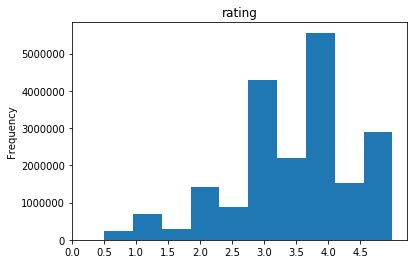

In [30]:
ratings["rating"].plot(kind="hist", title="rating")
plt.rcParams["patch.force_edgecolor"] = True
plt.xticks(np.arange(0, 5, 0.5))

In [31]:
movies2 = pd.DataFrame(movies.genres.str.split('|').tolist(), 
                       index=movies.movieId).stack()
movies2 = movies2.reset_index([0, 'movieId'])
movies2.columns = ['movieId', 'genre']

In [32]:
genre_summary = movies2.groupby('genre').count()
genre_summary = genre_summary.sort_values(by='movieId', ascending=False)
print(genre_summary)

                    movieId
genre                      
Drama               5677224
Comedy              4218720
Thriller            2266152
Romance             1976256
Action              1939032
Crime               1408872
Adventure           1324272
Horror              1152816
Sci-Fi              1020840
Fantasy              783960
Children             699360
Mystery              693720
Documentary          525648
Animation            515496
War                  496320
Musical              452328
Western              247032
IMAX                 184992
Film-Noir            126336
(no genres listed)     1128


In [33]:
#text = genre_summary.genre[0]
#wordcloud = WordCloud().generate(text)

In [34]:
tag_group = tag.groupby("movieId").agg(lambda x: x.tolist())

In [35]:
tag_group.head()

,userId,tag,timestamp
movieId,,,
1,"[1644, 1741, 1741, 1741, 1741, 2299, 3596, 359...","[Watched, computer animation, Disney animated ...","[2014-12-04 23:44:40, 2007-07-08 13:59:15, 200..."
2,"[1629, 1741, 1741, 1741, 1741, 1741, 1741, 174...","[time travel, adapted from:book, board game, c...","[2014-03-10 17:42:00, 2007-05-12 19:02:03, 200..."
3,"[2274, 14260, 18390, 20434, 20434, 23068, 2707...","[old people that is actually funny, sequel fev...","[2008-04-19 05:15:14, 2006-02-06 04:30:32, 200..."
4,"[9197, 9197, 58612, 58612, 71833, 123297]","[chick flick, revenge, characters, chick flick...","[2011-06-20 08:36:17, 2011-06-20 08:36:17, 201..."
5,"[9197, 9197, 9197, 9197, 9197, 14260, 18390, 2...","[Diane Keaton, family, sequel, Steve Martin, w...","[2011-05-16 05:14:49, 2006-01-12 21:49:34, 200..."


In [36]:
tag_group.drop('userId', axis=1, inplace=True)

In [97]:
tag_group.drop('timestamp', axis=1, inplace=True)

In [98]:
tag_group = pd.merge(tag_group, movie, on="movieId")

In [41]:
tag_group.head()

,tag,timestamp
movieId,,
1,"[Watched, computer animation, Disney animated ...","[2014-12-04 23:44:40, 2007-07-08 13:59:15, 200..."
2,"[time travel, adapted from:book, board game, c...","[2014-03-10 17:42:00, 2007-05-12 19:02:03, 200..."
3,"[old people that is actually funny, sequel fev...","[2008-04-19 05:15:14, 2006-02-06 04:30:32, 200..."
4,"[chick flick, revenge, characters, chick flick...","[2011-06-20 08:36:17, 2011-06-20 08:36:17, 201..."
5,"[Diane Keaton, family, sequel, Steve Martin, w...","[2011-05-16 05:14:49, 2006-01-12 21:49:34, 200..."


In [42]:
cols3 = tag_group.columns.tolist()
cols3

['tag', 'timestamp']

In [43]:
cols3 = ['movieId', 'title', 'tag', 'genres']

In [44]:
tag_group.head()

,tag,timestamp
movieId,,
1,"[Watched, computer animation, Disney animated ...","[2014-12-04 23:44:40, 2007-07-08 13:59:15, 200..."
2,"[time travel, adapted from:book, board game, c...","[2014-03-10 17:42:00, 2007-05-12 19:02:03, 200..."
3,"[old people that is actually funny, sequel fev...","[2008-04-19 05:15:14, 2006-02-06 04:30:32, 200..."
4,"[chick flick, revenge, characters, chick flick...","[2011-06-20 08:36:17, 2011-06-20 08:36:17, 201..."
5,"[Diane Keaton, family, sequel, Steve Martin, w...","[2011-05-16 05:14:49, 2006-01-12 21:49:34, 200..."


In [45]:
tag_group.to_csv('out.csv')

In [46]:
tag_group2 = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/out.csv")

In [47]:
tag_group2.head()

,movieId,title,year,tag,genres,avg_rating
0,1,Toy Story,1995,Watched computer animation Disney animated fea...,Adventure|Animation|Children|Comedy|Fantasy,3.921240
1,2,Jumanji,1995,time travel adapted from:book board game child...,Adventure|Children|Fantasy,3.211977
2,3,Grumpier Old Men,1995,old people that is actually funny sequel fever...,Comedy|Romance,3.151040
3,4,Waiting to Exhale,1995,chick flick revenge characters chick flick cha...,Comedy|Drama|Romance,2.861393
4,5,Father of the Bride Part II,1995,Diane Keaton family sequel Steve Martin weddin...,Comedy,3.064592


In [48]:
tag_group2.shape

(19545, 6)

In [49]:
tfidf = TfidfVectorizer(stop_words='english')
tag_group2['tag'] = tag_group2['tag'].fillna('')
tfidf_matrix = tfidf.fit_transform(tag_group2['tag'])
tfidf_matrix.shape

(19545, 24007)

In [50]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [51]:
indices = pd.Series(tag_group2.index, index=tag_group2['title']).drop_duplicates()

In [52]:
indices

title
Toy Story                                                       0
Jumanji                                                         1
Grumpier Old Men                                                2
Waiting to Exhale                                               3
Father of the Bride Part II                                     4
Heat                                                            5
Sabrina                                                         6
Tom and Huck                                                    7
Sudden Death                                                    8
GoldenEye                                                       9
American President, The                                        10
Dracula: Dead and Loving It                                    11
Balto                                                          12
Nixon                                                          13
Cutthroat Island                                               14
Casi

Content-based recommender

In [53]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the most similar movies
    sim_scores = sim_scores[1:21]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top most similar movies
    return tag_group2['title'].iloc[movie_indices]

In [115]:
get_recommendations('Lord of the Rings, The')

4228       4993
5053       5952
16967    106489
15648     98809
6094       7153
11899     70802
3127       3725
11963     71160
7667      26403
18783    118696
4141       4896
9111      41566
1756       2161
10609     58105
10774     59501
1738       2140
11141     63121
7682      26436
8001      27249
8667      33376
Name: movieId, dtype: int64

In [ ]:
recommends = []
n = 0
for n in range(tag_group2.shape[0]):
    rec = get_recommendations(n)
    recommends.append(rec)
    print(rec)
    n += 1

In [ ]:
with open("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/recommends.csv",'w') as f:
    for sublist in recommends:
        for item in sublist:
            f.write(str(item) + ',')
        f.write('\n')

In [ ]:
rating_avg = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/rating_avg.csv")

In [ ]:
rating_avg = pd.merge(rating_avg, movie, on="movieId")

In [ ]:
rating_avg.drop('year', axis=1, inplace=True)

In [ ]:
rating_avg.head()

In [ ]:
res = pd.get_dummies(rating_avg['genres'].str.split('|').apply(pd.Series).stack()).sum(level=0)

In [ ]:
res

In [ ]:
res.to_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/res.csv")

In [ ]:
rating_avg.to_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/movie_w_target.csv")

In [ ]:
movie_w_target = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/movie_w_target.csv")

In [ ]:
movie_w_target.head()

In [ ]:
movie_w_target.shape

In [ ]:
avg_rating_20 = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/recommends.csv")

In [ ]:
mg = pd.merge(movie_w_target, avg_rating_20, on="movieId")

In [ ]:
mg.head()

In [ ]:
cols = ['avg_rating',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'avg_rating_20']
mg = mg[cols]

In [ ]:
mg.head()

In [ ]:
mg = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/content.csv")

In [ ]:
recommends_lg = []
n = 0
for n in range(tag_group2.shape[0]):
    rec = get_recommendations(n)
    recommends_lg.append(rec)
    n += 1

In [ ]:
# Getting the rating given by a user to a movie.
def get_rating_(userid,movieid):
    return (ratings.loc[(ratings.userId==userid) & (ratings.movieId == movieid),'rating'].iloc[0])
# Getting the list of all movie ids the specified user has rated.
def get_movieids_(userid):
    return (ratings.loc[(ratings.userId==userid),'movieId'].tolist())
# Getting the movie titles against the movie id.
def get_movie_title_(movieid):
    return (movies.loc[(ratings.movieId == movieid),'title'].iloc[0])
def distance_similarity_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # Count of movies watched by both the users.
    both_watch_count = 0
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            both_watch_count += 1
    if both_watch_count == 0 :
        return 0
    
    # Calculating distance based similarity between both the users.
    distance = []
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            rating1 = get_rating_(user1,element)
            rating2 = get_rating_(user2,element)
            distance.append(pow(rating1 - rating2, 2))
    total_distance = sum(distance)
    
    # Adding one to the denominator to avoid divide by zero error.
    return 1/(1+math.sqrt(total_distance))

In [ ]:
rating.head()

In [ ]:
high_users = rating.groupby('userId', as_index=False)['rating'].count()
high_users = high_users.sort_values(by='rating', ascending=False)
high_users.head()

In [ ]:
print('Distance based similarity between user ids 1 & 500: {}'.format(distance_similarity_score(1,500)))

In [ ]:
def pearson_correlation_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # A list of movies watched by both the users.
    both_watch_count = []
    
    # Finding movies watched by both the users.
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            both_watch_count.append(element)
    
    # Returning '0' correlation for bo common movies.
    if len(both_watch_count) == 0 :
        return 0
    
    # Calculating Co-Variances.
    rating_sum_1 = sum([get_rating_(user1,element) for element in both_watch_count])
    rating_sum_2 = sum([get_rating_(user2,element) for element in both_watch_count])
    rating_squared_sum_1 = sum([pow(get_rating_(user1,element),2) for element in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating_(user2,element),2) for element in both_watch_count])
    product_sum_rating = sum([get_rating_(user1,element) * get_rating_(user2,element) for element in both_watch_count])
    
    # Returning pearson correlation between both the users.
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = math.sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    
    # Handling 'Divide by Zero' error.
    if denominator == 0:
        return 0
    return numerator/denominator

In [ ]:
print('Pearson Corelation between user ids 11 & 30: {}'.format(pearson_correlation_score(11,30)))

In [ ]:
def most_similar_users_(user1,number_of_users,metric='pearson'):
    '''
    user1 : Targeted User
    number_of_users : number of most similar users you want to user1.
    metric : metric to be used to calculate inter-user similarity score. ('pearson' or else)
    '''
    # Getting distinct user ids.
    user_ids = ratings.userId.unique().tolist()
    
    # Getting similarity score between targeted and every other suer in the list(or subset of the list).
    if(metric == 'pearson'):
        similarity_score = [(pearson_correlation_score(user1,nth_user),nth_user) 
                            for nth_user in user_ids[:100] if nth_user != user1]
    else:
        similarity_score = [(distance_similarity_score(user1,nth_user),nth_user) 
                            for nth_user in user_ids[:100] if nth_user != user1]
    
    # Sorting in descending order.
    similarity_score.sort()
    similarity_score.reverse()
    
    # Returning the top most 'number_of_users' similar users. 
    return similarity_score[:number_of_users]

In [ ]:
#print(most_similar_users_(23,5))

In [ ]:
def get_recommendation_(userid):
    user_ids = ratings.userId.unique().tolist()
    total = {}
    similariy_sum = {}
    
    # Iterating over subset of user ids.
    for user in user_ids[:100]:
        
        # not comparing the user to itself (obviously!)
        if user == userid:
            continue
        
        # Getting similarity score between the users.
        score = pearson_correlation_score(userid,user)
        
        # not considering users having zero or less similarity score.
        if score <= 0:
            continue
        
        # Getting weighted similarity score and sum of similarities between both the users.
        for movieid in get_movieids_(user):
            # Only considering not watched/rated movies
            if movieid not in get_movieids_(userid) or get_rating_(userid,movieid) == 0:
                total[movieid] = 0
                total[movieid] += get_rating_(user,movieid) * score
                similariy_sum[movieid] = 0
                similariy_sum[movieid] += score
    
    # Normalizing ratings
    ranking = [(tot/similariy_sum[movieid],movieid) for movieid,tot in total.items()]
    ranking.sort()
    ranking.reverse()
    
    # Getting movie titles against the movie ids.
    recommendations = [get_movie_title_(movieid) for score,movieid in ranking]
    return recommendations[:10]

In [ ]:
#print(get_recommendation_(32))

In [3]:
movie2 = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/movies/movie2.csv")

In [4]:
movie2.head()

,movieId,title,genres,revenue,budget,popularity,vote_average,vote_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415
1,2,Jumanji,Adventure|Children|Fantasy,262797249,65000000,17.015539,6.9,2413
2,4,Waiting to Exhale,Comedy|Drama|Romance,81452156,16000000,3.859495,6.1,34
3,6,Heat,Action|Crime|Thriller,187436818,60000000,17.924927,7.7,1886
4,9,Sudden Death,Action,64350171,35000000,5.231580,5.5,174


In [7]:
rating2 = pd.merge(movie2, rating, on="movieId")

In [16]:
movie3 = movie2

In [14]:
movie3 = movie2.drop('genres', axis=1, inplace=True)
movie3 = movie2.drop('revenue', axis=1, inplace=True)
movie3 = movie2.drop('budget', axis=1, inplace=True)
movie3 = movie2.drop('popularity', axis=1, inplace=True)
movie3 = movie2.drop('vote_average', axis=1, inplace=True)
movie3 = movie2.drop('vote_count', axis=1, inplace=True)

In [17]:
movie3.head()

,movieId,title
0,1,Toy Story
1,2,Jumanji
2,4,Waiting to Exhale
3,6,Heat
4,9,Sudden Death


In [8]:
rating2.head()

,movieId,title,genres,revenue,budget,popularity,vote_average,vote_count,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,11,4.5,2009-01-02 01:13:41


In [18]:
g_scores2 = pd.merge(movie2, g_scores, on="movieId")

In [21]:
g_scores2.head()

,movieId,title,tagId
0,1,Toy Story,1
1,1,Toy Story,2
2,1,Toy Story,3
3,1,Toy Story,4
4,1,Toy Story,5


In [20]:
g_scores2.drop('relevance', axis=1, inplace=True)

In [22]:
tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [23]:
tag2 = pd.merge(movie2, tag, on="movieId")

In [25]:
tag2.head()

,movieId,title,userId,tag,timestamp
0,1,Toy Story,1644,Watched,2014-12-04 23:44:40
1,1,Toy Story,1741,computer animation,2007-07-08 13:59:15
2,1,Toy Story,1741,Disney animated feature,2007-07-08 22:21:47
3,1,Toy Story,1741,Pixar animation,2007-07-08 22:46:10
4,1,Toy Story,1741,TÃ©a Leoni does not star in this movie,2009-06-15 19:19:33


In [26]:
tag_group22 = tag2.groupby("movieId").agg(lambda x: x.tolist())

In [27]:
tag_group22.head()

,title,userId,tag,timestamp
movieId,,,,
1,"[Toy Story, Toy Story, Toy Story, Toy Story, T...","[1644, 1741, 1741, 1741, 1741, 2299, 3596, 359...","[Watched, computer animation, Disney animated ...","[2014-12-04 23:44:40, 2007-07-08 13:59:15, 200..."
2,"[Jumanji, Jumanji, Jumanji, Jumanji, Jumanji, ...","[1629, 1741, 1741, 1741, 1741, 1741, 1741, 174...","[time travel, adapted from:book, board game, c...","[2014-03-10 17:42:00, 2007-05-12 19:02:03, 200..."
4,"[Waiting to Exhale, Waiting to Exhale, Waiting...","[9197, 9197, 58612, 58612, 71833, 123297]","[chick flick, revenge, characters, chick flick...","[2011-06-20 08:36:17, 2011-06-20 08:36:17, 201..."
6,"[Heat, Heat, Heat, Heat, Heat, Heat, Heat, Hea...","[1849, 2492, 2492, 2492, 2931, 2931, 2931, 293...","[realistic action, Al Pacino, Michael Mann, Ro...","[2013-05-13 19:07:37, 2010-09-29 11:36:31, 201..."
9,"[Sudden Death, Sudden Death, Sudden Death, Sud...","[24718, 24718, 24718, 28780, 45619, 45928, 702...","[action, jean-claude van damme, Peter Hyams, J...","[2013-05-01 13:04:31, 2013-05-01 13:04:31, 201..."


In [28]:
tag_group22.drop('title', axis=1, inplace=True)
tag_group22.drop('userId', axis=1, inplace=True)
tag_group22.drop('timestamp', axis=1, inplace=True)

In [29]:
tag_group22.head()

,tag
movieId,
1,"[Watched, computer animation, Disney animated ..."
2,"[time travel, adapted from:book, board game, c..."
4,"[chick flick, revenge, characters, chick flick..."
6,"[realistic action, Al Pacino, Michael Mann, Ro..."
9,"[action, jean-claude van damme, Peter Hyams, J..."


In [30]:
tag_group22.to_csv('out2.csv')

In [74]:
tag_group22 = pd.read_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/out2.csv")

In [75]:
tag_group22.head()

,movieId,title,tag,avg_rating
0,1,Toy Story,"Watched, computer animation, Disney animated f...",3.921240
1,2,Jumanji,"time travel, adapted from:book, board game, ch...",3.211977
2,4,Waiting to Exhale,"chick flick, revenge, characters, chick flick,...",2.861393
3,6,Heat,"realistic action, Al Pacino, Michael Mann, Rob...",3.834930
4,9,Sudden Death,"action, jean-claude van damme, Peter Hyams, Je...",3.004924


In [69]:
tfidf2 = TfidfVectorizer(stop_words='english')
tag_group22['tag'] = tag_group22['tag'].fillna('')
tfidf_matrix2 = tfidf2.fit_transform(tag_group22['tag'])
tfidf_matrix2.shape

(3177, 13352)

In [70]:
cosine_sim2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)

In [95]:
indices2 = pd.Series(tag_group22.index, index=tag_group22['movieId']).drop_duplicates()

In [96]:
indices2

movieId
1            0
2            1
4            2
6            3
9            4
10           5
14           6
15           7
16           8
17           9
18          10
19          11
20          12
21          13
23          14
25          15
27          16
34          17
36          18
44          19
45          20
46          21
48          22
52          23
69          24
70          25
71          26
75          27
76          28
81          29
          ... 
120637    3147
120825    3148
121231    3149
121241    3150
121275    3151
121618    3152
121741    3153
121889    3154
122062    3155
122878    3156
125914    3157
125916    3158
126548    3159
126579    3160
127096    3161
127108    3162
127134    3163
127178    3164
127194    3165
127196    3166
127198    3167
127262    3168
127319    3169
128520    3170
129428    3171
129657    3172
129707    3173
130073    3174
130490    3175
131013    3176
Length: 3177, dtype: int64

In [119]:
def get_recommendations(eyed, cosine_sim2=cosine_sim2):
    # Get the index of the movie that matches the title
    idx = indices2[eyed]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores2 = list(enumerate(cosine_sim2[idx]))

    # Sort the movies based on the similarity scores
    sim_scores2 = sorted(sim_scores2, key=lambda x: x[1], reverse=True)

    # Get the scores of the most similar movies
    sim_scores2 = sim_scores2[1:16]

    # Get the movie indices
    movie_indices2 = [i[0] for i in sim_scores2]

    # Return the top most similar movies
    return tag_group22['movieId'].iloc[movie_indices2]

In [120]:
mid = []
for di in tag_group22['movieId']:
    mid.append(di)

In [121]:
recommends2 = []
for n2 in mid:
    rec2 = get_recommendations(n2)
    recommends2.append(rec2)
    print(rec2)

765       3114
1160      4886
1217      5218
1393      6377
2503     78499
2033     50872
2916    103141
2336     68954
1945     45517
1255      5444
1038      4306
561       2294
1871     40339
2209     60069
164        596
Name: movieId, dtype: int64
407      1702
135       500
182       765
840      3448
1272     5528
852      3489
603      2431
2386    71429
1938    45208
1551     7292
1738    26567
2005    49274
291      1246
1964    46972
562      2297
Name: movieId, dtype: int64
3009    109483
2708     90576
2303     66203
645       2581
1362      6155
879       3594
2363     70643
1028      4246
55         168
488       1993
1848     36525
1230      5299
1065      4447
2806     96565
95         339
Name: movieId, dtype: int64
2237    61697
789      3252
814      3362
1031     4262
1861    38992
773      3173
906      3735
116       431
1219     5220
1769    30825
637      2539
949      3948
354      1466
763      3107
282      1213
Name: movieId, dtype: int64
693       2807
107

Name: movieId, dtype: int64
131      485
321     1359
1502    7004
1085    4558
185      786
1081    4531
1436    6664
82       256
867     3527
719     2916
159      589
373     1587
1189    5040
764     3113
1201    5093
Name: movieId, dtype: int64
1425      6617
1416      6560
2974    106839
2405     71876
1801     32781
1761     27837
858       3505
160        590
256       1084
2714     90719
1553      7294
123        458
1349      5962
241       1027
197        851
Name: movieId, dtype: int64
1366     6168
694      2812
169       639
1055     4371
1763    27864
435      1840
1872    40574
2297    65810
1399     6481
21         46
26         71
563      2298
1316     5781
1946    45527
2192    59116
Name: movieId, dtype: int64
2494    78022
693      2807
4           9
151       546
1011     4199
2261    63222
402      1681
19         44
1746    26696
2307    66639
838      3444
107       379
124       464
1851    37380
1012     4200
Name: movieId, dtype: int64
933       3837
714  

162       594
515      2096
163       595
2564    81847
2262    63239
1038     4306
1630     8360
158       588
245      1032
2094    54259
1578     7380
771      3159
164       596
2138    56152
881      3615
Name: movieId, dtype: int64
1425      6617
1007      4159
1209      5127
3011    109569
2149     56626
160        590
752       3034
813       3361
109        383
70         208
1226      5282
858       3505
2287     65181
1024      4238
1095      4611
Name: movieId, dtype: int64
540      2180
1992    48700
403      1688
164       596
158       588
1534     7163
163       595
1964    46972
304      1282
22         48
2138    56152
445      1907
666      2687
515      2096
1807    33237
Name: movieId, dtype: int64
501       2018
752       3034
1575      7374
2783     95105
1871     40339
881       3615
1004      4154
22          48
164        596
163        595
17          34
158        588
1393      6377
323       1367
2925    103755
Name: movieId, dtype: int64
2563    81834
1877

283       1214
2376     71135
89         316
2746     92192
277       1200
1854     37727
1225      5266
85         282
1837     34405
311       1301
910       3745
1334      5881
846       3471
3160    126579
811       3354
Name: movieId, dtype: int64
554       2269
863       3513
1089      4572
2926    103883
2181     58743
1222      5237
1650      8622
76         225
3112    116887
181        762
16          27
157        587
2072     53129
731       2956
139        516
Name: movieId, dtype: int64
1189    5040
108      380
131      485
1436    6664
1081    4531
185      786
321     1359
1085    4558
867     3527
1502    7004
82       256
159      589
719     2916
764     3113
584     2373
Name: movieId, dtype: int64
606       2443
646       2583
263       1095
249       1054
66         194
1405      6510
155        555
2896    101973
398       1673
981       4034
40         125
1486      6942
1184      5013
83         266
2074     53322
Name: movieId, dtype: int64
283       1214
277

Name: movieId, dtype: int64
490      1995
489      1994
1741    26638
674      2717
2802    96281
48        158
2615    85788
157       587
535      2174
892      3686
2703    90469
683      2743
818      3395
894      3689
997      4123
Name: movieId, dtype: int64
2988    107769
140        519
895       3690
2069     53121
835       3440
797       3273
1676      8854
731       2956
2457     74750
167        611
2263     63436
1411      6537
2671     88932
482       1984
1815     33644
Name: movieId, dtype: int64
494      2001
495      2002
448      1918
37        110
2444    74156
1983    48304
974      4018
379      1597
1267     5502
615      2490
192       832
1211     5152
900      3704
564      2301
1187     5027
Name: movieId, dtype: int64
493      2000
495      2002
37        110
448      1918
2444    74156
1983    48304
379      1597
974      4018
1267     5502
615      2490
192       832
900      3704
1211     5152
564      2301
141       520
Name: movieId, dtype: int64
494  

1342      5944
319       1356
91         329
327       1373
328       1374
325       1371
326       1372
2329     68358
2905    102445
329       1375
330       1376
775       3175
1837     34405
2201     59392
1809     33493
Name: movieId, dtype: int64
2780    94959
35        101
2413    72226
1113     4665
505      2026
620      2500
394      1663
709      2888
692      2806
1299     5673
925      3809
119       441
799      3276
1281     5564
1203     5106
Name: movieId, dtype: int64
457      1936
463      1948
459      1944
456      1935
461      1946
453      1930
470      1959
468      1955
458      1940
904      3719
214       920
462      1947
309      1293
2735    91571
413      1721
Name: movieId, dtype: int64
1075     4502
730      2953
1485     6936
156       586
496      2003
228       953
1512     7047
321      1359
1801    32781
2134    55955
1493     6957
1306     5694
1486     6942
2271    64032
1035     4290
Name: movieId, dtype: int64
594       2404
14          23
201

2394     71571
1620      8062
1399      6481
2072     53129
3106    116191
26          71
563       2298
1316      5781
1946     45527
2192     59116
2665     88485
2904    102354
2914    102974
2976    106881
3066    112655
Name: movieId, dtype: int64
2188    59014
1275     5541
1932    44972
918      3785
125       466
1482     6888
2526    80350
2233    61348
751      3033
1264     5481
1729    26386
141       520
1415     6550
362      1517
506      2027
Name: movieId, dtype: int64
882       3617
583       2372
1557      7317
2795     95488
582       2371
2706     90528
872       3552
553       2265
2876    100390
1554      7300
1956     46578
843       3457
641       2558
67         196
3151    121275
Name: movieId, dtype: int64
100        356
147        539
1260      5464
976       4022
1522      7102
602       2424
137        508
2954    105504
2980    107141
517       2100
1352      5989
43         150
2332     68554
507       2028
0            1
Name: movieId, dtype: int64
505

2988    107769
895       3690
140        519
2069     53121
835       3440
2263     63436
167        611
482       1984
1304      5691
1411      6537
483       1985
475       1974
2408     72129
492       1998
484       1986
Name: movieId, dtype: int64
782       3210
3083    113780
2876    100390
1276      5547
103        365
247       1041
1707      8996
944       3919
1811     33499
175        674
1199      5080
1582      7437
1787     31696
1921     44238
2932    104211
Name: movieId, dtype: int64
1453     6769
1265     5485
2308    66665
1663     8784
590      2395
2780    94959
2618    86000
1617     8037
166       608
1635     8376
96        342
1757    27706
150       543
1837    34405
1299     5673
Name: movieId, dtype: int64
391      1647
2059    52456
1265     5485
705      2876
2535    80748
433      1831
1774    31116
1633     8368
2311    66915
305      1283
523      2123
1845    36397
1877    40815
2422    72701
382      1608
Name: movieId, dtype: int64
985       4043
128

612      2476
1139     4803
1152     4855
1246     5382
721      2921
1269     5506
2278    64614
351      1459
1465     6814
722      2922
2555    81512
296      1266
1361     6078
126       474
1474     6870
Name: movieId, dtype: int64
421       1753
119        441
1178      4989
2086     53956
1760     27831
244       1031
2067     52973
2043     51255
183        778
2987    107718
1682      8874
582       2371
1244      5377
2573     82463
463       1948
Name: movieId, dtype: int64
1093     4594
1997    48783
2020    50068
757      3066
1039     4310
1019     4223
1842    34536
299      1272
874      3555
1252     5420
507      2028
2748    92234
604      2436
1639     8446
612      2476
Name: movieId, dtype: int64
714       2901
112        407
747       3018
26          71
563       2298
1316      5781
1946     45527
2192     59116
2665     88485
2904    102354
2914    102974
2976    106881
3066    112655
1613      7984
67         196
Name: movieId, dtype: int64
1095      4611
114

1111      4661
791       3256
192        832
3067    112780
379       1597
576       2353
292       1248
2505     78774
142        521
3095    114849
1024      4238
2532     80590
262       1092
858       3505
363       1518
Name: movieId, dtype: int64
248     1044
521     2121
624     2513
902     3708
574     2340
1377    6250
318     1345
522     2122
746     3017
854     3499
1003    4148
520     2119
1565    7347
1291    5630
1683    8881
Name: movieId, dtype: int64
1562     7325
949      3948
451      1923
1964    46972
2219    60756
1451     6763
1537     7173
1769    30825
2334    68793
1655     8641
40        125
1643     8528
1369     6188
2578    82852
1963    46970
Name: movieId, dtype: int64
1401      6483
432       1822
194        837
173        661
2706     90528
1557      7317
2097     54331
882       3617
2876    100390
1554      7300
641       2558
3151    121275
1714     25934
1768     30793
1695      8949
Name: movieId, dtype: int64
2845     98239
2288     65193
234

Name: movieId, dtype: int64
2756    92751
79        246
1577     7378
2407    72011
435      1840
1199     5080
377      1592
477      1979
2822    97172
713      2900
2270    64030
880      3608
1526     7147
1673     8835
2491    77820
Name: movieId, dtype: int64
1866     39414
26          71
563       2298
1316      5781
1946     45527
2192     59116
2665     88485
2904    102354
2914    102974
2976    106881
3066    112655
1549      7285
843       3457
67         196
1237      5340
Name: movieId, dtype: int64
30         86
582      2371
887      3646
1644     8531
2515    79588
1840    34530
925      3809
1488     6947
2162    57669
992      4085
823      3421
2754    92535
2043    51255
2490    77800
2086    53956
Name: movieId, dtype: int64
153      548
39       122
1099    4619
347     1427
1075    4502
996     4104
1087    4565
1000    4132
991     4084
94       338
1086    4564
431     1816
1141    4812
178      711
951     3961
Name: movieId, dtype: int64
2022    50153
955   

Name: movieId, dtype: int64
2388    71460
2417    72424
2866    99941
1606     7781
1507     7019
1236     5337
2282    64997
2688    89780
1623     8132
1732    26462
1808    33321
1717    25971
1992    48700
1120     4703
1110     4654
Name: movieId, dtype: int64
320      1358
1644     8531
388      1627
582      2371
887      3646
2162    57669
644      2580
1859    38061
2754    92535
183       778
2203    59594
2576    82744
1581     7419
473      1965
1840    34530
Name: movieId, dtype: int64
50         160
76         225
426       1779
499       2011
297       1270
500       2012
3096    114935
860       3510
1088      4571
1106      4638
610       2469
2186     58972
2155     56941
3040    111362
2966    106240
Name: movieId, dtype: int64
2335     68952
2162     57669
587       2387
1446      6730
2826     97306
3093    114713
2490     77800
386       1623
1644      8531
486       1991
2284     65126
582       2371
887       3646
272       1175
183        778
Name: movieId, dty

613      2485
247      1041
986      4052
2573    82463
936      3877
782      3210
2072    53129
1602     7708
1853    37384
2251    62439
798      3274
649      2600
2615    85788
2683    89480
2114    55245
Name: movieId, dtype: int64
2567     82095
3072    113071
404       1690
2772     94018
3149    121231
3168    127262
1268      5504
2766     93610
400       1676
637       2539
1022      4232
1456      6779
2605     85131
1219      5220
1267      5502
Name: movieId, dtype: int64
1516      7070
3120    117466
851       3487
116        431
615       2490
1107      4640
1774     31116
1031      4262
1772     31042
236       1000
1719     26085
637       2539
428       1785
1760     27831
282       1213
Name: movieId, dtype: int64
1520      7081
2798     95744
2737     91628
3047    111622
1137      4782
611       2470
2117     55272
2244     62155
2158     57368
59         175
825       3425
856       3501
1049      4358
1675      8850
1957     46604
Name: movieId, dtype: int64
237

268       1126
806       3322
700       2859
307       1288
2070     53123
1340      5941
2003     49220
587       2387
2964    106100
1601      7647
183        778
1737     26550
1434      6646
357       1487
1461      6802
Name: movieId, dtype: int64
856      3501
1049     4358
1675     8850
1957    46604
2384    71343
2595    84732
2731    91492
1017     4212
1788    31700
2440    73929
2213    60223
1577     7378
1206     5109
2710    90620
2273    64114
Name: movieId, dtype: int64
783      3213
2008    49314
331      1377
161       592
922      3793
657      2640
1722    26152
1652     8636
376      1591
1239     5349
2083    53550
868      3535
658      2641
45        153
1408     6534
Name: movieId, dtype: int64
1447     6731
1579     7387
2175    58332
1568     7360
1403     6502
1082     4532
2068    53000
230       968
713      2900
2143    56174
2178    58485
2392    71535
2113    55232
1626     8225
1678     8861
Name: movieId, dtype: int64
2577     82767
3084    114007
566

1115      4675
1734     26485
182        765
1365      6166
1783     31490
281       1208
779       3190
610       2469
3111    116823
1608      7836
2711     90624
2638     87192
2687     89774
771       3159
2596     84772
Name: movieId, dtype: int64
2667     88518
3062    112481
1368      6186
200        862
1290      5625
2331     68552
1711     25830
2522     80004
1784     31553
2276     64519
1634      8369
1992     48700
559       2290
2720     91054
2711     90624
Name: movieId, dtype: int64
2849     98373
3079    113567
2947    105086
2023     50158
879       3594
1525      7142
726       2942
1559      7320
258       1088
3073    113103
273       1188
2525     80222
1923     44613
2584     83424
987       4054
Name: movieId, dtype: int64
678       2723
984       4040
1002      4141
2055     52287
1268      5504
2558     81564
657       2640
1826     34129
1775     31150
1903     43869
1652      8636
3077    113348
1441      6705
1124      4719
586       2384
Name: movieId, d

2867     99957
650       2605
1354      5991
2202     59404
2350     69712
2577     82767
1704      8984
2614     85565
850       3481
429       1792
1986     48342
2186     58972
3000    108689
1475      6873
2537     80831
Name: movieId, dtype: int64
3095    114849
1156      4868
2236     61465
2139     56156
2987    107718
947       3946
2211     60074
2558     81564
1145      4821
2210     60072
948       3947
105        373
2668     88672
3156    122878
2276     64519
Name: movieId, dtype: int64
2899    102123
692       2806
2343     69436
505       2026
620       2500
709       2888
1281      5564
1968     47122
670       2706
1635      8376
1203      5106
989       4068
334       1381
444       1895
2528     80549
Name: movieId, dtype: int64
1119      4701
555       2273
1363      6156
884       3624
1642      8526
2206     59784
1593      7482
24          69
1639      8446
1194      5055
448       1918
2639     87222
582       2371
2886    101088
887       3646
Name: movieId, d

899       3702
910       3745
631       2529
630       2528
1108      4643
1160      4886
0            1
2376     71135
2143     56174
994       4092
2333     68791
1217      5218
765       3114
2895    101864
1403      6502
Name: movieId, dtype: int64
1052      4367
2257     63062
2512     79293
1234      5324
1118      4699
1417      6564
2135     55995
3048    111659
56         170
3095    114849
1226      5282
1924     44665
1024      4238
1381      6285
1095      4611
Name: movieId, dtype: int64
42         145
1785     31685
2558     81564
2279     64716
61         180
2604     85056
659       2642
922       3793
3103    115617
1652      8636
657       2640
678       2723
1364      6157
1239      5349
660       2643
Name: movieId, dtype: int64
2661     88179
2291     65585
2982    107348
2921    103335
2290     65567
2116     55267
1655      8641
2792     95309
2089     53993
1662      8782
2479     76293
2508     79091
2930    104078
2370     70800
2696     90264
Name: movieId, d

1025     4239
1700     8970
1413     6539
31         89
2071    53125
1742    26680
93        337
1949    45722
77        235
972      4014
1565     7347
560      2291
2150    56757
758      3081
2774    94478
Name: movieId, dtype: int64
2677     89087
2170     58162
2243     62113
3131    118876
2043     51255
3107    116213
1682      8874
2925    103755
2639     87222
2487     77665
3122    117851
2069     53121
17          34
501       2018
2596     84772
Name: movieId, dtype: int64
3106    116191
611       2470
2548     80947
2267     63853
3100    115381
1876     40723
2571     82447
96         342
199        853
273       1188
2406     71899
1311      5747
899       3702
80         247
362       1517
Name: movieId, dtype: int64
2811     96691
2523     80026
2272     64037
2178     58485
2705     90524
2918    103249
2859     99373
1626      8225
2672     89028
1082      4532
2581     83086
1568      7360
1579      7387
2175     58332
2599     84942
Name: movieId, dtype: int64
306

Name: movieId, dtype: int64
2375    71011
2076    53406
2437    73608
1711    25830
1853    37384
2389    71466
582      2371
887      3646
616      2491
1644     8531
1044     4343
1288     5617
1840    34530
670      2706
1560     7323
Name: movieId, dtype: int64
2076    53406
2375    71011
2562    81817
1939    45210
1965    46974
2575    82527
1824    33905
1711    25830
2436    73587
2053    51931
2583    83293
2389    71466
2542    80862
2700    90428
2005    49274
Name: movieId, dtype: int64
693       2807
4            9
1011      4199
2261     63222
1746     26696
107        379
1012      4200
838       3444
1091      4580
232        990
124        464
2879    100579
111        393
1097      4614
2475     76130
Name: movieId, dtype: int64
3171    129428
2454     74641
2338     69187
3142    120138
1764     27878
3050    111795
2655     88069
2258     63082
309       1293
2649     87522
1636      8377
2967    106330
1438      6682
2941    104379
2394     71571
Name: movieId, dty

Name: movieId, dtype: int64
2648     87520
2360     70336
3077    113348
2604     85056
2344     69526
2772     94018
2644     87306
2101     54768
2860     99415
896       3697
2884    101025
2450     74530
2063     52668
3029    110553
69         204
Name: movieId, dtype: int64
1160      4886
2921    103335
1393      6377
0            1
2558     81564
765       3114
2982    107348
1217      5218
2503     78499
1138      4799
2033     50872
2916    103141
2116     55267
2380     71264
2336     68954
Name: movieId, dtype: int64
649      2600
419      1748
1158     4878
1543     7254
562      2297
2391    71530
1569     7361
2572    82461
2448    74458
2218    60684
1858    37857
2010    49530
2300    66097
1689     8914
1352     5989
Name: movieId, dtype: int64
667       2694
1257      5449
2933    104218
1552      7293
2283     65088
1758     27808
2207     59900
36         104
2607     85367
1382      6287
1948     45672
202        886
2306     66509
2718     90890
72         216
Nam

247      1041
1343     5945
466      1952
1707     8996
362      1517
2827    97462
613      2485
236      1000
313      1305
1694     8946
665      2683
567      2318
1670     8830
931      3831
2086    53956
Name: movieId, dtype: int64
1409     6535
2761    93326
1289     5620
2271    64032
1065     4447
1848    36525
2122    55284
2630    86548
1672     8833
1878    40819
638      2541
2470    76030
2590    84557
622      2504
2549    80969
Name: movieId, dtype: int64
2437     73608
2562     81817
1824     33905
2617     85881
1695      8949
2105     54999
1939     45210
3124    117881
2239     61707
2076     53406
3170    128520
2021     50149
1965     46974
2152     56782
2375     71011
Name: movieId, dtype: int64
2456     74698
320       1358
2265     63483
2358     70305
3070    112911
2897    102033
695       2835
2885    101076
1493      6957
388       1627
2947    105086
1576      7376
1982     48161
1851     37380
855       3500
Name: movieId, dtype: int64
1823     33836
308

378       1593
2382     71325
1887     42007
2932    104211
1537      7173
2607     85367
2779     94953
2162     57669
1644      8531
1493      6957
621       2502
2303     66203
1392      6373
582       2371
1859     38061
Name: movieId, dtype: int64
1945     45517
765       3114
1160      4886
1217      5218
0            1
2503     78499
2033     50872
1393      6377
2916    103141
2756     92751
2336     68954
2745     92008
2603     85022
2728     91386
2828     97701
Name: movieId, dtype: int64
2454     74641
1582      7437
3171    129428
2439     73881
2725     91241
2338     69187
2169     58111
2258     63082
2584     83424
2141     56167
1764     27878
3050    111795
2458     74787
2999    108514
1636      8377
Name: movieId, dtype: int64
2092     54001
2563     81834
2353     69844
1327      5816
1877     40815
1633      8368
1900     43560
2110     55110
1341      5943
566       2316
2912    102903
1034      4275
1188      5039
244       1031
2094     54259
Name: movieId, d

1577      7378
2742     91886
1726     26309
1282      5572
2767     93740
2565     82053
2491     77820
2606     85261
2654     87876
2992    107987
2729     91474
820       3408
2749     92259
43         150
1767     30749
Name: movieId, dtype: int64
69         204
1144      4816
996       4104
1109      4649
2478     76251
834       3439
365       1552
2476     76175
3103    115617
2604     85056
922       3793
370       1573
1652      8636
564       2301
1804     33158
Name: movieId, dtype: int64
2273     64114
3030    110603
1994     48711
306       1287
985       4043
2421     72696
2501     78422
1009      4190
1280      5563
2968    106438
3019    109897
2083     53550
1789     31869
956       3980
2008     49314
Name: movieId, dtype: int64
505      2026
620      2500
709      2888
692      2806
2252    62733
2814    96811
2828    97701
1281     5564
2753    92420
2175    58332
1203     5106
334      1381
989      4068
1968    47122
2158    57368
Name: movieId, dtype: int64
69 

1525      7142
1972     47382
2947    105086
2023     50158
3079    113567
726       2942
2525     80222
879       3594
3073    113103
1559      7320
1923     44613
2584     83424
1295      5664
203        899
2637     87004
Name: movieId, dtype: int64
3058    112303
3073    113103
2967    106330
1460      6797
1643      8528
251       1060
1792     32029
1912     43936
2074     53322
324       1370
246       1036
65         193
54         165
234        996
1830     34162
Name: movieId, dtype: int64
2898    102064
1254      5440
1625      8201
2985    107702
2015     49793
3027    110453
1252      5420
753       3037
1983     48304
3050    111795
1547      7263
160        590
2061     52460
1504      7016
1555      7315
Name: movieId, dtype: int64
2842    98111
1498     6986
804      3307
0           1
1           2
2           4
3           6
4           9
5          10
6          14
7          15
8          16
9          17
10         18
11         19
Name: movieId, dtype: int64
297

378       1593
2382     71325
1887     42007
2607     85367
1537      7173
2779     94953
2653     87869
621       2502
2303     66203
1392      6373
2289     65230
1931     44864
2528     80549
2818     96917
2871    100108
Name: movieId, dtype: int64
667      2694
1257     5449
2283    65088
1758    27808
36        104
2207    59900
1552     7293
1382     6287
202       886
72        216
2607    85367
2306    66509
1948    45672
1299     5673
2053    51931
Name: movieId, dtype: int64
2478     76251
2958    105731
45         153
97         344
1652      8636
11          19
922       3793
356       1485
912       3752
1392      6373
3103    115617
2198     59315
1757     27706
2065     52722
2640     87232
Name: movieId, dtype: int64
2234     61350
2880    100611
803       3300
1270      5507
3069    112852
1592      7481
2746     92192
897       3699
2883    100810
277       1200
283       1214
400       1676
1078      4526
2638     87192
846       3471
Name: movieId, dtype: int64
628

1789     31869
2089     53993
1990     48600
2440     73929
1374      6225
3030    110603
2370     70800
2696     90264
1662      8782
2499     78174
306       1287
3017    109864
395       1665
619       2498
2371     70869
Name: movieId, dtype: int64
2985    107702
598       2410
600       2412
2898    102064
597       2409
1555      7315
467       1954
1623      8132
287       1228
1817     33660
79         246
599       2411
1181      5009
1298      5669
1829     34153
Name: movieId, dtype: int64
2659     88140
2963    106072
2486     77561
2628     86332
1776     31221
2303     66203
1828     34150
3069    112852
1445      6711
1881     41285
1652      8636
2065     52722
922       3793
2223     60950
2198     59315
Name: movieId, dtype: int64
1990     48600
710       2889
3019    109897
2089     53993
1488      6947
2440     73929
1789     31869
3077    113348
3123    117871
2759     93270
876       3578
2127     55765
1374      6225
94         338
1817     33660
Name: movieId, d

Name: movieId, dtype: int64
120    442
0        1
1        2
2        4
3        6
4        9
5       10
6       14
7       15
8       16
9       17
10      18
11      19
12      20
13      21
Name: movieId, dtype: int64
1093     4594
1039     4310
757      3066
1842    34536
299      1272
1019     4223
507      2028
2748    92234
874      3555
2020    50068
1639     8446
604      2436
995      4103
1997    48783
932      3836
Name: movieId, dtype: int64
348       1432
3118    117415
1299      5673
1323      5803
3089    114250
250       1056
398       1673
3081    113604
568       2322
35         101
150        543
772       3160
1687      8908
2152     56782
3017    109864
Name: movieId, dtype: int64
2995    108190
2818     96917
2610     85399
956       3980
2836     97921
1914     44191
511       2067
1614      7988
1339      5903
1826     34129
1899     43558
2504     78574
2990    107916
630       2528
1896     42943
Name: movieId, dtype: int64
1089      4572
731       2956
30   

In [122]:
with open("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/recommends3.csv",'w') as f:
    for sublist in recommends2:
        for item in sublist:
            f.write(str(item) + ',')
        f.write('\n')

In [110]:
tag_group22.to_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/tag_group22.csv")

([<matplotlib.axis.XTick at 0x2dc15043ac8>,
 <a list of 10 Text xticklabel objects>)

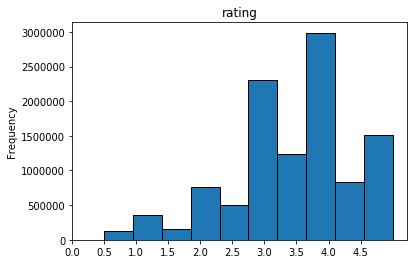

In [125]:
rating2["rating"].plot(kind="hist", title="rating")
plt.rcParams["patch.force_edgecolor"] = True
plt.xticks(np.arange(0, 5, 0.5))

In [128]:
res = pd.get_dummies(movie2['genres'].str.split('|').apply(pd.Series).stack()).sum(level=0)

In [129]:
res.to_csv("C:/Users/arito/Documents/DePaul/DSC540/Final Project/data/res.csv")

In [9]:
rating2.head()

,movieId,title,genres,revenue,budget,popularity,vote_average,vote_count,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,11,4.5,2009-01-02 01:13:41


In [19]:
high_users = rating2.groupby('userId', as_index=False)['rating'].count()
high_users = high_users.sort_values(by='rating', ascending=False)
high_users.head()

,userId,rating
74138,74142,2151
8404,8405,2022
118201,118205,1922
59474,59477,1912
46467,46470,1869


In [20]:
high_users.shape

(138489, 2)

In [24]:
top_100 = high_users[0:100]
top_100.drop('rating', axis=1, inplace=True)

In [25]:
top_100.head()

,userId
74138,74142
8404,8405
118201,118205
59474,59477
46467,46470


In [27]:
rating2.head()

,movieId,title,genres,revenue,budget,popularity,vote_average,vote_count,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,11,4.5,2009-01-02 01:13:41


In [28]:
parsed_rating2 = pd.merge(top_100, rating2, on="userId")

In [30]:
parsed_rating2.head()

,userId,movieId,title,genres,revenue,budget,popularity,vote_average,vote_count,rating,timestamp
0,74142,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,373554033,30000000,21.946943,7.7,5415,5.0,2000-04-07 14:43:41
1,74142,2,Jumanji,Adventure|Children|Fantasy,262797249,65000000,17.015539,6.9,2413,0.5,2004-02-07 06:59:57
2,74142,4,Waiting to Exhale,Comedy|Drama|Romance,81452156,16000000,3.859495,6.1,34,0.5,2004-03-16 12:02:02
3,74142,6,Heat,Action|Crime|Thriller,187436818,60000000,17.924927,7.7,1886,4.0,2009-11-15 17:09:02
4,74142,9,Sudden Death,Action,64350171,35000000,5.231580,5.5,174,0.5,2004-09-05 10:19:18


In [32]:
parsed_rating2_vect = parsed_rating2
parsed_rating2_vect.drop('title', axis=1, inplace=True)
parsed_rating2_vect.drop('genres', axis=1, inplace=True)
parsed_rating2_vect.drop('revenue', axis=1, inplace=True)
parsed_rating2_vect.drop('budget', axis=1, inplace=True)
parsed_rating2_vect.drop('popularity', axis=1, inplace=True)
parsed_rating2_vect.drop('vote_average', axis=1, inplace=True)
parsed_rating2_vect.drop('vote_count', axis=1, inplace=True)
parsed_rating2_vect.drop('timestamp', axis=1, inplace=True)

In [33]:
parsed_rating2_vect.head()

,userId,movieId,rating
0,74142,1,5.0
1,74142,2,0.5
2,74142,4,0.5
3,74142,6,4.0
4,74142,9,0.5


In [36]:
R_df = parsed_rating2_vect.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
R_df.head()

movieId,1,2,4,6,9,10,14,15,16,17,...,126422,127096,127319,128215,128592,128975,129428,129937,130073,130746
userId,,,,,,,,,,,,,,,,,,,,,
3907,4.0,2.5,0.0,4.0,0.0,4.0,3.0,0.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4358,5.0,3.0,0.0,5.0,3.0,5.0,0.0,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7201,4.5,1.0,0.0,2.0,0.0,3.0,0.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8405,5.0,3.0,0.0,4.0,2.0,2.5,3.0,1.5,3.5,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8963,2.5,0.0,3.5,3.5,4.0,3.0,3.0,0.0,3.0,4.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
R = R_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

C:\Users\arito\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [40]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [41]:
sigma = np.diag(sigma)

In [42]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)

In [46]:
preds_df.shape

(100, 3216)

In [47]:
preds_df.head()

movieId,1,2,4,6,9,10,14,15,16,17,...,126422,127096,127319,128215,128592,128975,129428,129937,130073,130746
0,3.807213,1.160280,-0.860600,4.150334,0.680246,3.625361,2.192746,0.781484,3.670156,2.551851,...,0.123307,-0.021152,-0.126390,0.037568,-0.004998,-0.079378,0.051561,-0.016994,-0.102198,0.021986
1,4.497199,3.594540,0.415249,5.043027,3.178276,5.253515,-0.107663,1.081224,4.007325,3.548616,...,0.109414,0.103051,-0.088162,0.114322,0.057478,0.071904,0.015268,-0.144273,0.080130,0.229561
2,4.379665,1.716110,-0.667755,2.104803,0.114273,2.707528,-0.546777,2.394112,2.449997,4.934231,...,0.028893,0.036182,0.143290,0.140295,0.057157,0.081850,-0.019394,-0.016913,0.097345,0.083633
3,4.813445,2.870029,1.432529,4.773552,1.463971,3.394020,2.857585,1.587622,4.273696,4.217104,...,0.080678,0.214244,0.076896,0.121526,0.120799,0.098293,0.110331,-0.033834,0.087815,0.121090
4,2.274663,0.555633,1.977181,3.062328,1.438782,2.875410,3.079000,0.678556,3.285822,4.068605,...,1.207637,0.243660,0.013798,0.315054,0.125618,0.157115,0.532534,0.201689,0.161356,0.505122


In [51]:
preds_df_t = preds_df.T

In [52]:
preds_df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.807213,4.497199,4.379665,4.813445,2.274663,2.939705,2.906831,2.302343,1.072694,4.425467,...,4.779300,1.388503,3.940341,5.425506,3.205119,3.523330,4.639120,3.984842,3.600068,3.101764
2,1.160280,3.594540,1.716110,2.870029,0.555633,1.909561,3.243476,2.131987,2.566576,1.197820,...,2.831699,2.781723,0.362485,1.753353,2.780975,1.986345,4.961562,0.981855,1.457729,2.468953
4,-0.860600,0.415249,-0.667755,1.432529,1.977181,0.896725,0.681884,0.877985,0.893465,0.241417,...,0.003755,0.448239,-0.476193,-0.252735,0.175442,-0.265142,0.225899,-0.155515,0.662367,-0.433416
6,4.150334,5.043027,2.104803,4.773552,3.062328,3.366633,3.023296,3.010006,3.350758,4.381720,...,0.006601,3.771875,4.093049,4.514980,3.484201,3.718800,5.369668,3.187390,4.437873,4.371754
9,0.680246,3.178276,0.114273,1.463971,1.438782,2.859445,1.564011,2.800846,1.203769,0.929137,...,3.380720,3.398696,0.773969,0.053991,-0.268646,1.451554,-0.185588,2.804670,1.640199,0.962699


In [54]:
preds_df_t.to_csv('preds_df_collab.csv')